Project 4: Natural Language Processing and Unsupervised Learning<br/>

In this notebook, I try to do the following techniques on my reddit r/medicine 2020 post data:
* PCA
* tSNE
* kMeans Clustering

# Table of Contents
1. [Imports](#section1)
2. [Getting Post Data from SQL Database](#section2)
3. [PCA & tSNE](#section3)
4. [kMeans Clustering](#section4)

<a id='section1'></a>

### 1. Imports

In [75]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

# imports for accessing SQL database
import psycopg2 as pg

# for text preprocessing
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# for PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# for kMeans Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# for tSNE
from sklearn.manifold import TSNE
from itertools import cycle

<a id='section2'></a>

### 2. Getting Post Data from SQL Database

In [2]:
# Postgres info to connect

connection_args = {
                   'host': 'localhost', # we are connecting to our local version of psql
                   'dbname': 'reddit_medicine', # DB we are connecting to
                   'port': 5432, # port we opened
                   'password': '',
                   'user': 'postgres'
                   }

In [3]:
def connect_to_postgres(connection_args):
    '''
    Connect to PostgreSQL database
    Inputs:
    - connection_args: parameters to connect to psql db
    Output:
    - connection: connection to the psql db
    '''
    connection = None
    try:
        connection = pg.connect(**connection_args)
    except (Exception, pg.DatabaseError) as error:
        print(error)
    
    return connection

In [4]:
connection = connect_to_postgres(connection_args)

In [5]:
# exclude megathreads with repetitive post titles and submissions
reddit_query = "SELECT * FROM submissions \
                WHERE title NOT LIKE 'Megathread:%' \
                AND title NOT LIKE 'Megathread #%' \
                AND title NOT LIKE 'Weekly Careers Thread';"

reddit_df = pd.read_sql(reddit_query, connection)
connection.close()

In [6]:
reddit_df["full_text"] = reddit_df["title"] + ' ' + reddit_df["submission_text"]

<a id='section3'></a>

### 3. PCA & tSNE

In [10]:
# in order to do PCA, I should clean my data first!
def my_cleaning_function(text, regex_patterns, char_space, char_no_space, abbrev_dict):
    '''
    Inputs:
    - text (string): string of reddit posts
    - regex_patterns (list): list of regex patterns to remove
    - char_space (string): characters to replace with a space
    - char_no_space (string): characters to replace with no space
    - abbrev_dict (dict): dictionary to replace abbreviations with full words
    Outputs:
    - cleaned_text (string): cleaned string of reddit posts
    '''
    
    cleaned_text = []
    
    for post in text:
        
        for pattern in regex_patterns:
            post = re.sub(pattern, ' ', post)
    
        for char in char_space:
            post = post.replace(char, ' ')
    
        for char in char_no_space:
            post = post.replace(char, '')
        
        for key in abbrev_dict.keys():
            post = post.replace(key, ' ' + abbrev_dict[key] + ' ')
    
        post = post.lower()
        
        cleaned_text.append(post)
    
    return cleaned_text

In [11]:
# for my cleaning function
regex_patterns = ['\n', '\t', r'https?:\/\/\S+', r'&\S*', r'\xa0', r'[__]{2,}', r'[\d]+', 'χ', '®']
char_space = '^*>|[]()",°#.:%?'
char_no_space = '/-\\'
abbrev_dict = {"MD": "doctor_of_medicine",
               "MPH": "master_of_public_health",
               "MBA": "master_of_business_administrationi",
               "NP": "nurse_practitioner",
               "PA": "physician_assistant",
               "RN": "registered_nurse",
               "DVM": "doctor_of_veterinary_medicine",
               "DDS": "doctor_of_dentistry",
               "DO": "doctor_of_osteopathy",
               "ICU": "intensive_care_unit",
               "ER": "emergency_room",
               "ED": "emergency_department",
               "EMS": "emergency_medical_services",
               "EMR": "electronic_medical_records",
               "CFR": "case_fatality_rate",
               "CT": "computed_tomography",
               "CDC": "centers_for_disease_control",
               "WHO": "world_health_organization",
               "FDA": "food_and_drug_administration",
               "SARS": "severe_acute_respiratory_syndrome",
               "MERS": "middle_east_respiratory_syndrome",
               "ARDS": "acute_respiratory_distress_syndrome",
               "SOM": "school_of_medicine",
               "COVID": "covid", # make sure the word covid is distinct
               "N95": "n_ninety_fifty", # make sure n-95 masks are distinct words
               "PPE": "personal_protective_equipment"
               }

In [12]:
cleaned_text = my_cleaning_function(reddit_df["full_text"], regex_patterns, char_space, char_no_space, abbrev_dict)

In [13]:
cleaned_text[:5]

['testimony of a surgeon working in bergamo  in the heart of italys coronavirus outbreak «in one of the nonstop emails that i receive from my hospital administration on a more than daily basis  there was a paragraph on  how to be responsible on social media   with some recommendations that we all can agree on  after thinking for a long time if and what to write about whats happening here  i felt that silence was not responsible  i will therefore try to convey to laypeople  those who are more distant from our reality  what we are experiencing in bergamo during these covid  pandemic days  i understand the need not to panic  but when the message of the danger of what is happening is not out  and i still see people ignoring the recommendations and people who gather together complaining that they cannot go to the gym or play soccer tournaments  i shiver  i also understand the economic damage and i am also worried about that  after this epidemic  it will be hard to start over   still  beside

In [20]:
vectorizer = TfidfVectorizer(min_df=3, max_df=0.7, ngram_range=(2,3), stop_words='english')

In [21]:
vectorized_text = vectorizer.fit_transform(cleaned_text)

In [22]:
pd.DataFrame(vectorized_text.toarray(), columns=vectorizer.get_feature_names())

,aa physician_assistant,able help,able make,able practice,able say,academic center,access care,act like,actual evidence,actual patient,...,years residency,years study,yesterday saw,york city,york day,york times,young doctors,young female,young healthy,young people
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.206061
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.138578,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.104223,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [23]:
# try taking all data and plotting it on 2 dimensions
pca = PCA(n_components=2)
pca.fit(vectorized_text)
pcafeatures_ = pca.transform(vectorized_text)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [ ]:
# hm... looks like I can't do PCA because my TfIdf vectorizer is too sparse
# Seems like I already did PCA when I did TruncatedSVD

In [26]:
svd = TruncatedSVD(2)
svd.fit(vectorized_text)
svd_transform = svd.transform(vectorized_text)

In [28]:
explained_variance = svd.explained_variance_ratio_.sum()
explained_variance

0.024454983511216628

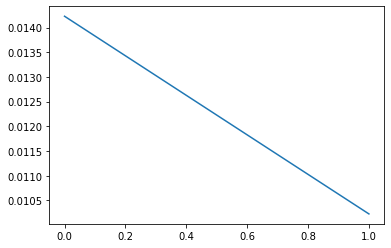

In [31]:
# scree plot?
plt.plot(svd.explained_variance_ratio_);

In [7]:
reddit_df.head()

,post_id,author,created_utc,month,title,submission_text,score,num_comments,stickied,url,full_text
0,ff8hns,mcgianni,1583647410,3,"Testimony of a surgeon working in Bergamo, in ...",«In one of the non-stop e-mails that I receive...,1,571,False,https://www.reddit.com/r/medicine/comments/ff8...,"Testimony of a surgeon working in Bergamo, in ..."
1,figd1n,indianola,1584181842,3,I posted a while back seeking a clinical portr...,Got this being passed around my circle of phys...,1,393,False,https://www.reddit.com/r/medicine/comments/fig...,I posted a while back seeking a clinical portr...
2,fg2rze,Light151,1583791324,3,Anyone else have colleagues who are still sayi...,I have been trying to raise awareness that our...,1,386,False,https://www.reddit.com/r/medicine/comments/fg2...,Anyone else have colleagues who are still sayi...
3,fi78id,dyingalonewithcats,1584135092,3,Latest CDC updates: best case/worst case scena...,,1,336,False,https://www.reddit.com/r/medicine/comments/fi7...,Latest CDC updates: best case/worst case scena...
4,fdznn0,half-taught-wrong,1583433075,3,[Serious] What is your plan if you or someone ...,I am trying to learn from medical colleagues. ...,1,322,False,https://www.reddit.com/r/medicine/comments/fdz...,[Serious] What is your plan if you or someone ...


<a id='section4'></a>

### 4. kMeans Clustering

In [45]:
# clustering with a random state of 10
num_clusters = 6 # I had 6 topics for my final LDA model

# n_init, number of times the K-mean algorithm will run
km = KMeans(n_clusters=num_clusters, random_state=10, n_init=1)

# do KMeans clustering on the TruncatedSVD (PCA) dimensionality reduced version of the text
km.fit(svd_transform)

KMeans(n_clusters=6, n_init=1, random_state=10)

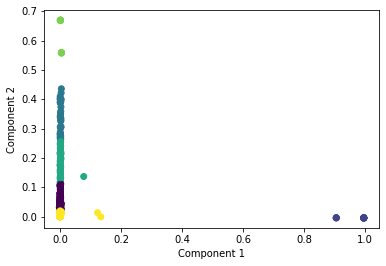

In [54]:
# somehow have clustering with SVD transformation?
plt.scatter(svd_transform[:,0],svd_transform[:,1], c=km.predict(svd_transform))
plt.xlabel("Component 1")
plt.ylabel("Component 2");

In [57]:
# trying MiniBatchKmeans on my vectorized text data
mini_km = MiniBatchKMeans(n_clusters=10, random_state = 10)
mini_km.fit(vectorized_text)

MiniBatchKMeans(n_clusters=10, random_state=10)

In [58]:
mini_km.predict(vectorized_text)

array([1, 1, 1, ..., 1, 3, 4], dtype=int32)

In [61]:
# reduce features to 2D
pca = PCA(n_components=2, random_state=10)
reduced_features = pca.fit_transform(vectorized_text.toarray())

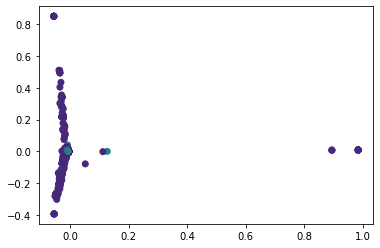

In [63]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=mini_km.predict(vectorized_text));

In [66]:
colors = cycle(['r','g','b','c','m','y','orange','k','aqua','yellow'])

In [67]:
# trying out tSNE

tSNE_model = TSNE(n_components=2, random_state=10)
low_data = tSNE_model.fit_transform(vectorized_text)

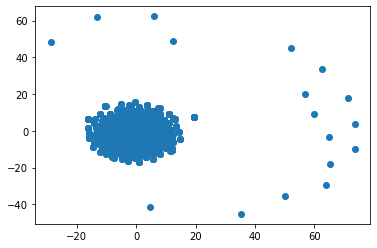

In [70]:
plt.scatter(low_data[:,0], low_data[:,1]);

In [71]:
def inertia_plot(data, max_clusters):
    inertias = []
    
    for k in range(1, max_clusters):
        km = KMeans(n_clusters=k)
        km.fit(data)
        inertias.append(km.inertia_)
    
    plt.plot(range(1, max_clusters), inertias, color='g')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    return plt.show()
    

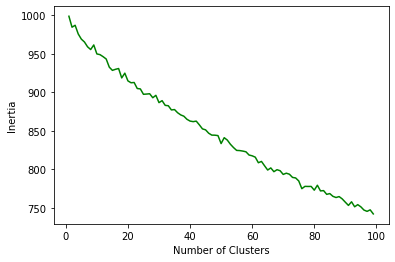

In [74]:
# trying out KMeans on my Tfidf vectorized text...
inertia_plot(vectorized_text, 100)

I have a topic document matrix that I could play around with.

In [76]:
with open('data/topic_matrix_df.pkl', 'rb') as f:
    topic_df = pickle.load(f)

In [77]:
topic_df.head()

,1st_topic,1st_topic_perc,2nd_topic,2nd_topic_perc,3rd_topic,3rd_topic_perc,4th_topic,4th_topic_perc,5th_topic,5th_topic_perc,6th_topic,6th_topic_perc,full_text,cleaned_text,month,1st_topic_mapped
0,1,0.6190,4,0.1544,5,0.1273,6,0.0472,3,0.0422,0,NaN,"Testimony of a surgeon working in Bergamo, in ...",testimony of a surgeon working in bergamo in ...,3,Medical Studies
1,5,0.4994,1,0.1907,6,0.1433,4,0.0791,3,0.0652,2,0.0222,I posted a while back seeking a clinical portr...,i posted a while back seeking a clinical portr...,3,Healthcare System
2,4,0.3974,1,0.3570,5,0.0844,3,0.0679,6,0.0511,2,0.0421,Anyone else have colleagues who are still sayi...,anyone else have colleagues who are still sayi...,3,Coronavirus Treatment
3,4,0.3988,1,0.2520,3,0.2080,6,0.0804,5,0.0407,2,0.0201,Latest CDC updates: best case/worst case scena...,latest centers_for_disease_control updates ...,3,Coronavirus Treatment
4,1,0.6501,3,0.1048,4,0.1011,2,0.0771,6,0.0572,0,NaN,[Serious] What is your plan if you or someone ...,serious what is your plan if you or someone ...,3,Medical Studies


In [ ]:
def display_cluster(data, km, num_clusters):
    '''
    Display clusters for a kMeans Clustering model
    Parameters:
    ----------
    - data: text data (must be vectorized using something like Tfidf)
    - km: an instance of KMeans
    - num_clusters: the number of clusters to generate
    '''
    color='brgcmyk'
    alpha=0.5
    s=20
    
    for i in range(num_clusters):
        plt.scatter(data[km.labels_==i,0], data[km.labels_==i,1],c=color[i], alpha=alpha, s=s)
        plt.scatter(km.cluster_centers_[i][0], km.cluster_centers_[i][1],c=color[i], alpha=alpha, s=s)

In [49]:
vectorized_text[km.labels_==0,0]

<222x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

ValueError: setting an array element with a sequence.

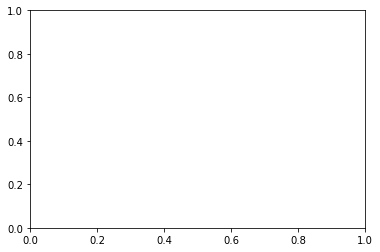

In [40]:
display_cluster(vectorized_text, km, num_clusters)